# Setup Notebook

* **Local Setup**: Put the notebook into a folder with csv file.

Note that outputs in this notebook is obtained by utilizing 01 - 15 November 2019 period as test data. 

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(1337)

# Task #1

In [2]:
dataset = pd.read_csv(
    'EPIAS_HW3_data.csv',
    skiprows=[0],
    header=None,
    names=['Date', 'Hour', 'Consumption'])

# merge date & hour into a single datetime column
dataset['Date'] = pd.to_datetime(dataset['Date'])

# convert consumption to int
dataset['Consumption'] = dataset['Consumption'].str.replace('.', '')
dataset['Consumption'] = dataset['Consumption'].str.replace(',', '.')
dataset['Consumption'] = dataset['Consumption'].astype(float)

# calculate test indices
test_indices = (dataset['Date'] >= '2019-11-01') & (dataset['Date'] < '2019-11-16')

# visualize dataframe
dataset[test_indices].head()

,Date,Hour,Consumption
26520,2019-11-01,00:00,32374.41
26521,2019-11-01,01:00,30373.63
26522,2019-11-01,02:00,29317.31
26523,2019-11-01,03:00,28639.16
26524,2019-11-01,04:00,28347.68


In [3]:
# calculate lag values
dataset['Lag_48'] = dataset['Consumption'].shift(48)
dataset['Lag_168'] = dataset['Consumption'].shift(168)

# get cols seperately 
consumption_test = dataset[test_indices]['Consumption'].values
lag_test = dataset[test_indices][['Lag_48', 'Lag_168']].values

def calculate_ape(preds, targets):
    ape = (targets - preds) / targets
    return np.abs(ape) * 100
    
def display_stats(data, axis=0):
    print('Min:', np.min(data, axis=axis))
    print('Mean (MAPE):', np.mean(data, axis=axis))
    print('Median:', np.median(data, axis=axis))
    print('Max:', np.max(data, axis=axis))

# calculate mape
print('Lag 48 | Lag 168 Deviation Statistics (in percentages):')
lag_ape = calculate_ape(lag_test, consumption_test[..., np.newaxis])
display_stats(lag_ape)

Lag 48 | Lag 168 Deviation Statistics (in percentages):
Min: [0.02475235 0.05779566]
Mean (MAPE): [7.09000228 7.28797096]
Median: [3.02881326 2.9036673 ]
Max: [76.31046141 47.5385792 ]


# Task #2

In [4]:
from sklearn.linear_model import LinearRegression

# calculate train indices
train_indices = (dataset['Date'] < '2019-11-01') & ~(dataset['Lag_168'].isnull())

# apply regression to train data
consumption_train = dataset[train_indices]['Consumption'].values
lag_train = dataset[train_indices][['Lag_48', 'Lag_168']].values
regression = LinearRegression().fit(lag_train, consumption_train)

# calculate predictions & consumption
preds = regression.predict(lag_test)

# calculate mape
print('Regression Deviation Statistics:')
reg_ape = calculate_ape(preds, consumption_test)
display_stats(reg_ape)

Regression Deviation Statistics:
Min: 0.020558680232560942
Mean (MAPE): 6.398170472869727
Median: 2.238138475031906
Max: 56.5303465483012


# Task #3

In [5]:
reg_hour_ape = []

# iterate over all hours
for i in range(24):
    # create regression datasets
    reg_train_x = lag_train[i::24, :]
    reg_train_y = consumption_train[i::24]

    reg_test_x = lag_test[i::24, :]
    reg_test_y = consumption_test[i::24]

    # get predictions
    regression = LinearRegression().fit(reg_train_x, reg_train_y)
    preds = regression.predict(reg_test_x)

    # calculate mape
    print('Regression Hour', i, 'Deviation Statistics:')
    preds_ape = calculate_ape(preds, reg_test_y)
    display_stats(preds_ape)
    print()

    reg_hour_ape.append(preds_ape)

print('Regression Full Deviation Statistics:')
display_stats(np.concatenate(reg_hour_ape))
reg_hour_ape = np.asarray(reg_hour_ape)

Regression Hour 0 Deviation Statistics:
Min: 0.019726496398452403
Mean (MAPE): 4.821853393590578
Median: 2.7446222163911846
Max: 21.606086051830133

Regression Hour 1 Deviation Statistics:
Min: 0.5075094357545573
Mean (MAPE): 5.370979858939752
Median: 3.1631537337241378
Max: 24.59524018394839

Regression Hour 2 Deviation Statistics:
Min: 0.21566782910226018
Mean (MAPE): 5.553394376972112
Median: 3.435592231504236
Max: 26.31053235952604

Regression Hour 3 Deviation Statistics:
Min: 0.45726392228568524
Mean (MAPE): 5.655459492843261
Median: 3.2223779497838567
Max: 28.138964218837874

Regression Hour 4 Deviation Statistics:
Min: 0.1759598520612964
Mean (MAPE): 5.4595711014864525
Median: 3.1996644053218093
Max: 28.011956059007492

Regression Hour 5 Deviation Statistics:
Min: 0.13177617301024644
Mean (MAPE): 5.036184712728695
Median: 2.22822225837106
Max: 25.94008266323536

Regression Hour 6 Deviation Statistics:
Min: 0.15978578008872857
Mean (MAPE): 4.6109561675963615
Median: 1.67118886980

# Task #4

In [6]:
# transform into wide format
cols = ['Date'] + [ 'Consumption_hour_' + str(i) for i in range(24) ]

dataset = dataset.pivot(index='Date', columns='Hour', values='Consumption').rename_axis(None, axis=1).reset_index()
dataset.columns = cols

# add lag values
for i in range(24):
    dataset['Lag_day2_hour_' + str(i)] = dataset['Consumption_hour_' + str(i)].shift(2)
    dataset['Lag_day7_hour_' + str(i)] = dataset['Consumption_hour_' + str(i)].shift(7)

dataset.head()

,Date,Consumption_hour_0,Consumption_hour_1,Consumption_hour_2,Consumption_hour_3,Consumption_hour_4,Consumption_hour_5,Consumption_hour_6,Consumption_hour_7,Consumption_hour_8,Consumption_hour_9,Consumption_hour_10,Consumption_hour_11,Consumption_hour_12,Consumption_hour_13,Consumption_hour_14,Consumption_hour_15,Consumption_hour_16,Consumption_hour_17,Consumption_hour_18,Consumption_hour_19,Consumption_hour_20,Consumption_hour_21,Consumption_hour_22,Consumption_hour_23,Lag_day2_hour_0,Lag_day7_hour_0,Lag_day2_hour_1,Lag_day7_hour_1,Lag_day2_hour_2,Lag_day7_hour_2,Lag_day2_hour_3,Lag_day7_hour_3,Lag_day2_hour_4,Lag_day7_hour_4,Lag_day2_hour_5,Lag_day7_hour_5,Lag_day2_hour_6,Lag_day7_hour_6,Lag_day2_hour_7,Lag_day7_hour_7,Lag_day2_hour_8,Lag_day7_hour_8,Lag_day2_hour_9,Lag_day7_hour_9,Lag_day2_hour_10,Lag_day7_hour_10,Lag_day2_hour_11,Lag_day7_hour_11,Lag_day2_hour_12,Lag_day7_hour_12,Lag_day2_hour_13,Lag_day7_hour_13,Lag_day2_hour_14,Lag_day7_hour_14,Lag_day2_hour_15,Lag_day7_hour_15,Lag_day2_hour_16,Lag_day7_hour_16,Lag_day2_hour_17,Lag_day7_hour_17,Lag_day2_hour_18,Lag_day7_hour_18,Lag_day2_hour_19,Lag_day7_hour_19,Lag_day2_hour_20,Lag_day7_hour_20,Lag_day2_hour_21,Lag_day7_hour_21,Lag_day2_hour_22,Lag_day7_hour_22,Lag_day2_hour_23,Lag_day7_hour_23
0,2016-01-01,26277.24,24991.82,23532.61,22464.78,22002.91,21957.08,22203.54,21844.16,23094.73,25202.27,27224.96,28908.04,28789.25,29367.70,29548.32,29390.89,30734.97,32048.02,31438.11,30728.47,30166.14,29461.28,29242.83,28069.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-02,27257.80,25692.59,24501.95,23973.46,23854.61,24195.66,25096.25,26488.24,32138.83,35430.82,36883.14,37775.08,36482.14,36700.05,36867.22,36463.13,36574.28,36950.55,35841.98,33929.92,33222.59,32524.16,32777.70,31448.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-03,27186.07,25679.76,24743.83,24405.31,24226.34,24727.59,24855.56,26277.09,30448.14,32151.77,32393.25,32510.51,30599.51,31027.69,30951.21,30912.11,31225.74,31593.27,32450.05,31631.05,30878.15,30006.60,30072.76,28402.03,26277.24,NaN,24991.82,NaN,23532.61,NaN,22464.78,NaN,22002.91,NaN,21957.08,NaN,22203.54,NaN,21844.16,NaN,23094.73,NaN,25202.27,NaN,27224.96,NaN,28908.04,NaN,28789.25,NaN,29367.70,NaN,29548.32,NaN,29390.89,NaN,30734.97,NaN,32048.02,NaN,31438.11,NaN,30728.47,NaN,30166.14,NaN,29461.28,NaN,29242.83,NaN,28069.09,NaN
3,2016-01-04,28668.70,27088.01,26088.12,25487.10,25456.17,25863.30,26033.30,27445.54,31497.83,33735.57,33811.78,34214.05,31995.59,30575.58,31628.11,32242.74,31879.52,31184.17,30890.59,32425.07,33040.97,32323.88,32119.82,30783.43,27257.80,NaN,25692.59,NaN,24501.95,NaN,23973.46,NaN,23854.61,NaN,24195.66,NaN,25096.25,NaN,26488.24,NaN,32138.83,NaN,35430.82,NaN,36883.14,NaN,37775.08,NaN,36482.14,NaN,36700.05,NaN,36867.22,NaN,36463.13,NaN,36574.28,NaN,36950.55,NaN,35841.98,NaN,33929.92,NaN,33222.59,NaN,32524.16,NaN,32777.70,NaN,31448.40,NaN
4,2016-01-05,26936.26,25629.65,24527.90,23673.93,23353.26,22219.82,21375.04,21885.64,23462.05,25288.95,26750.82,27516.07,26717.24,26960.56,26665.55,26899.98,26659.49,26247.08,26559.76,27835.99,29772.88,29524.28,29092.04,27215.41,27186.07,NaN,25679.76,NaN,24743.83,NaN,24405.31,NaN,24226.34,NaN,24727.59,NaN,24855.56,NaN,26277.09,NaN,30448.14,NaN,32151.77,NaN,32393.25,NaN,32510.51,NaN,30599.51,NaN,31027.69,NaN,30951.21,NaN,30912.11,NaN,31225.74,NaN,31593.27,NaN,32450.05,NaN,31631.05,NaN,30878.15,NaN,30006.60,NaN,30072.76,NaN,28402.03,NaN


In [0]:
# calculate feature cols
feature_cols = [ 'Lag_day2_hour_' + str(i) for i in range(24) ] + [ 'Lag_day7_hour_' + str(i) for i in range(24) ]

# calculate train/test indices
train_indices = (dataset['Date'] < '2019-11-01') & ~(dataset['Lag_day7_hour_0'].isnull())
test_indices = (dataset['Date'] >= '2019-11-01') & (dataset['Date'] < '2019-11-16')

# form train and test sets
train_x = dataset[train_indices][feature_cols].values
train_y = dataset[train_indices][cols[1:]].values
test_x = dataset[test_indices][feature_cols].values
test_y = dataset[test_indices][cols[1:]].values

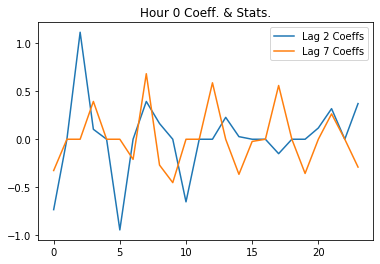

Min: 0.46318438917977545
Mean (MAPE): 5.607855852326824
Median: 3.0661823584175507
Max: 14.697855574288052


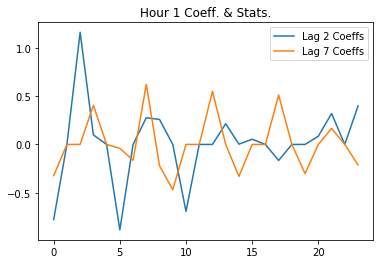

Min: 0.37217039794313433
Mean (MAPE): 5.7667332228172565
Median: 2.818909690744805
Max: 17.39487979111552


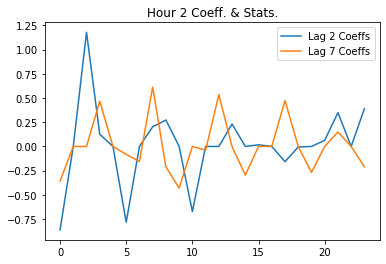

Min: 0.8517219209151928
Mean (MAPE): 5.813706653468797
Median: 3.649427210999539
Max: 19.516980952877134


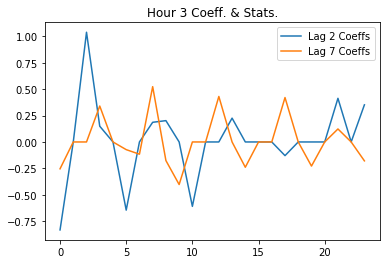

Min: 1.1827922040188574
Mean (MAPE): 5.774900670628463
Median: 3.7970506606382557
Max: 20.955757510418422


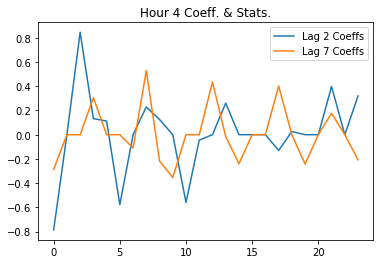

Min: 0.34503796727458236
Mean (MAPE): 5.518485374621597
Median: 3.504001359899055
Max: 21.406013689857534


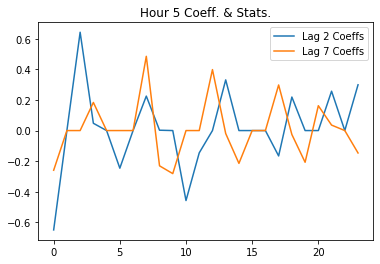

Min: 0.3266727919167284
Mean (MAPE): 5.306396957670971
Median: 3.0173305258756065
Max: 19.583161571895037


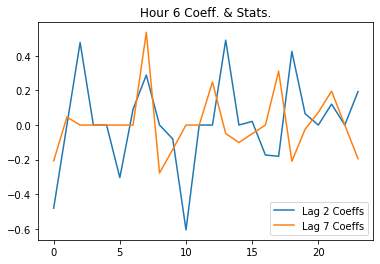

Min: 0.16439408133998917
Mean (MAPE): 5.317934099519766
Median: 4.084634393798854
Max: 21.422596806283362


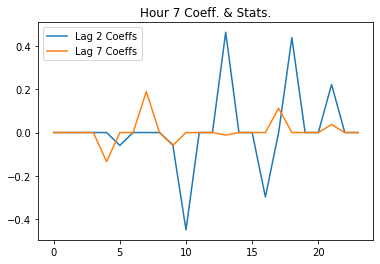

Min: 0.25787313886541147
Mean (MAPE): 7.083456515015961
Median: 4.303168242291134
Max: 27.91677907109658


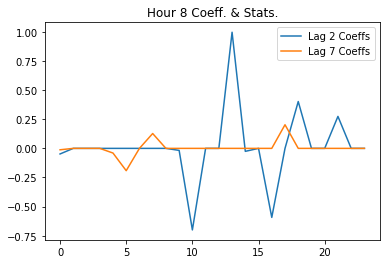

Min: 0.44918533685980727
Mean (MAPE): 9.569492386259649
Median: 6.075953074590501
Max: 47.592753761500205


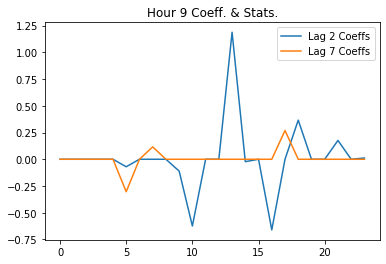

Min: 0.4435701296577266
Mean (MAPE): 9.714056869003482
Median: 4.502599021614102
Max: 59.14386953186115


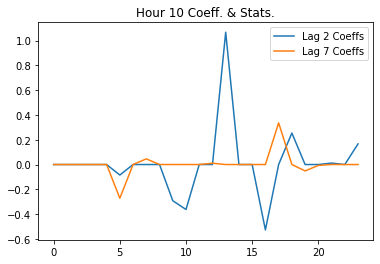

Min: 0.15135121020999004
Mean (MAPE): 9.110308232828029
Median: 3.609480332713871
Max: 63.302299214326666


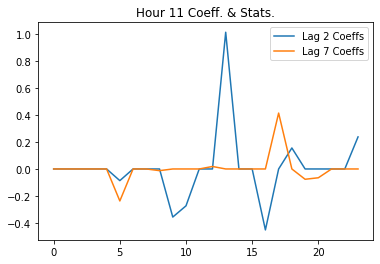

Min: 0.5266809053505344
Mean (MAPE): 9.006410241715527
Median: 3.778808367821862
Max: 64.54578137553075


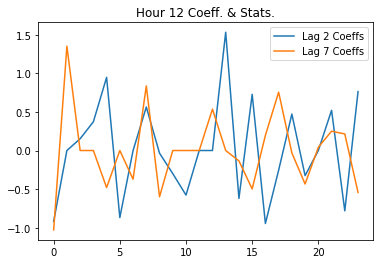

Min: 0.44522518281064416
Mean (MAPE): 9.129949250314402
Median: 4.575920340601426
Max: 62.28141718206691


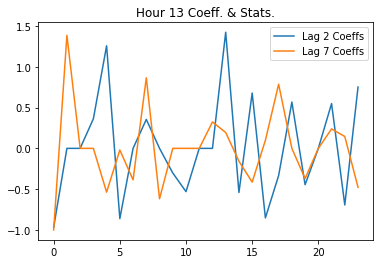

Min: 0.9138189650961935
Mean (MAPE): 8.834936324239658
Median: 4.219170657603732
Max: 60.567239928611535


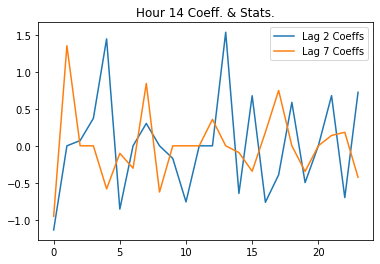

Min: 0.5992113512443531
Mean (MAPE): 8.826656275858312
Median: 4.181599569356065
Max: 61.75126619882975


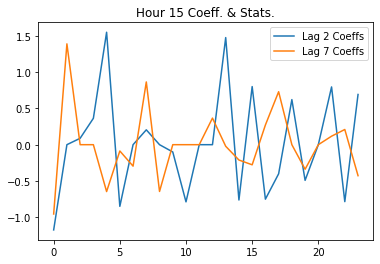

Min: 0.2591384232712099
Mean (MAPE): 8.54034925605382
Median: 4.862805918069288
Max: 57.527539905868984


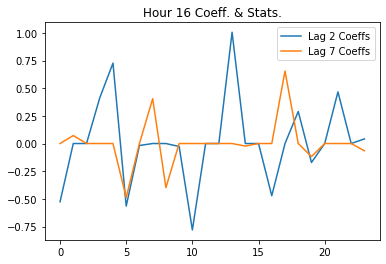

Min: 0.8226195215332932
Mean (MAPE): 7.743473793870062
Median: 4.5193903768309225
Max: 49.7616271508314


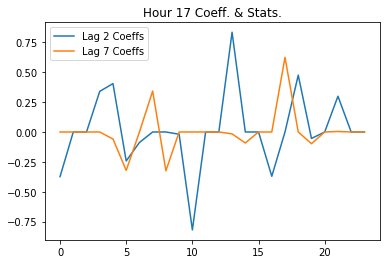

Min: 0.08331134363448736
Mean (MAPE): 7.417538754623167
Median: 5.091216729920124
Max: 41.36800139752686


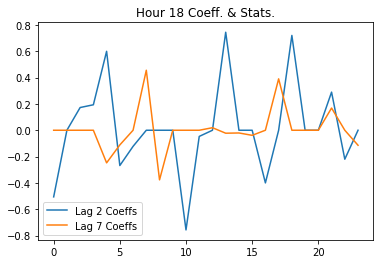

Min: 0.12554863888363454
Mean (MAPE): 5.810359973633917
Median: 3.696961106197179
Max: 32.95296018574289


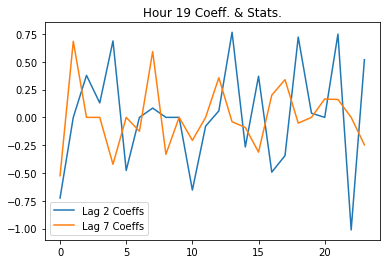

Min: 1.0197861421873216
Mean (MAPE): 5.244827636349359
Median: 3.264110978120148
Max: 28.3013952050604


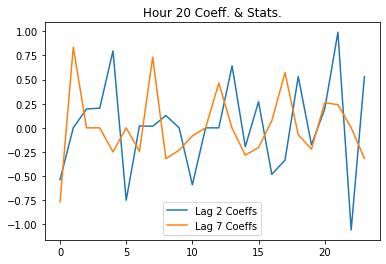

Min: 0.8677090300019239
Mean (MAPE): 5.118282315807039
Median: 4.119217309006875
Max: 23.285861871330717


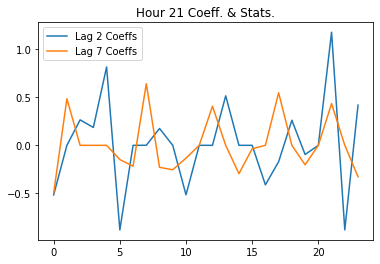

Min: 0.5391972163013611
Mean (MAPE): 4.713754527705219
Median: 3.6149410759574403
Max: 22.618018059750998


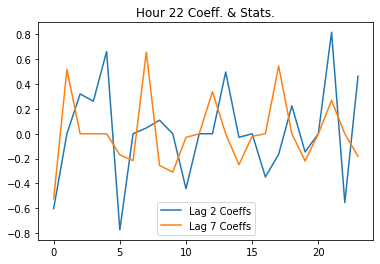

Min: 0.2693294941101387
Mean (MAPE): 4.488910474778669
Median: 3.0920620355472046
Max: 22.057934906177724


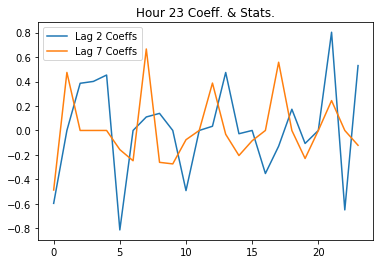

Min: 0.2602344359859905
Mean (MAPE): 4.50329557660651
Median: 3.710473177722742
Max: 20.2974297494454
Cross Validation Regression Full Deviation Statistics:
Min: 0.08331134363448736
Mean (MAPE): 6.831752968154852
Median: 3.9989365182019796
Max: 64.54578137553075


In [8]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import make_scorer

def mape(y_true, y_pred): 
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape_scorer = make_scorer(mape, greater_is_better=False)

reg_cv_ape = []
for i in range(24):
    regression = LassoCV(eps=0.001, max_iter=10000, cv=10).fit(train_x, train_y[:, i])
    preds = regression.predict(test_x)
    preds_ape = calculate_ape(preds, test_y[:, i])

    plt.figure()
    plt.title('Hour ' + str(i) + ' Coeff. & Stats.')
    plt.plot(regression.coef_[:24])
    plt.plot(regression.coef_[24:])
    plt.legend(['Lag 2 Coeffs', 'Lag 7 Coeffs'])
    plt.show()

    display_stats(preds_ape)
    reg_cv_ape.append(preds_ape)

print('Cross Validation Regression Full Deviation Statistics:')
display_stats(np.concatenate(reg_cv_ape))
reg_cv_ape = np.asarray(reg_cv_ape)

Most of the time we see a clean linearity in both lag-2 and lag-7 coefficients. Overall, lag-2 coefficients are more dominant especially in morning hours. We also see that in morning hours alpha values are much higher than others and performance in those hours are worse than linear regression without additional regularization. Sometimes we see that exact same hour in lag-2 or lag-7 coefficients attain negative values even though we believe them to be highly predictive.

# Task #5

# Task #6

In [9]:
def create_dataset(ape, name):
    days = []
    for i in range(int(len(ape) / 24)):
        days.append(np.tile(i, 24))
    days = np.concatenate(days)
    
    hours = np.tile([ i for i in range(24) ], int(len(ape) / 24))
    methods = np.tile(name, len(ape))

    data = np.asarray([ methods, days, hours, ape ])
    data = np.transpose(data)
    return data

data = np.concatenate([
    create_dataset(lag_ape[:, 0], 'Lag48'),
    create_dataset(lag_ape[:, 1], 'Lag168'),
    create_dataset(reg_ape, 'Regression'),
    create_dataset(reg_hour_ape.flatten(), 'Hour Based Reg.'),
    create_dataset(reg_cv_ape.flatten(), 'Cross Validation Reg.')
])

results = pd.DataFrame(data=data, columns=['Method', 'Day', 'Hour', 'Deviation'])
results['Hour'] = pd.to_numeric(results['Hour'])
results['Deviation'] = pd.to_numeric(results['Deviation'])
results.head()

,Method,Day,Hour,Deviation
0,Lag48,0,0,0.134180
1,Lag48,0,1,0.468038
2,Lag48,0,2,0.528016
3,Lag48,0,3,0.079227
4,Lag48,0,4,0.192749


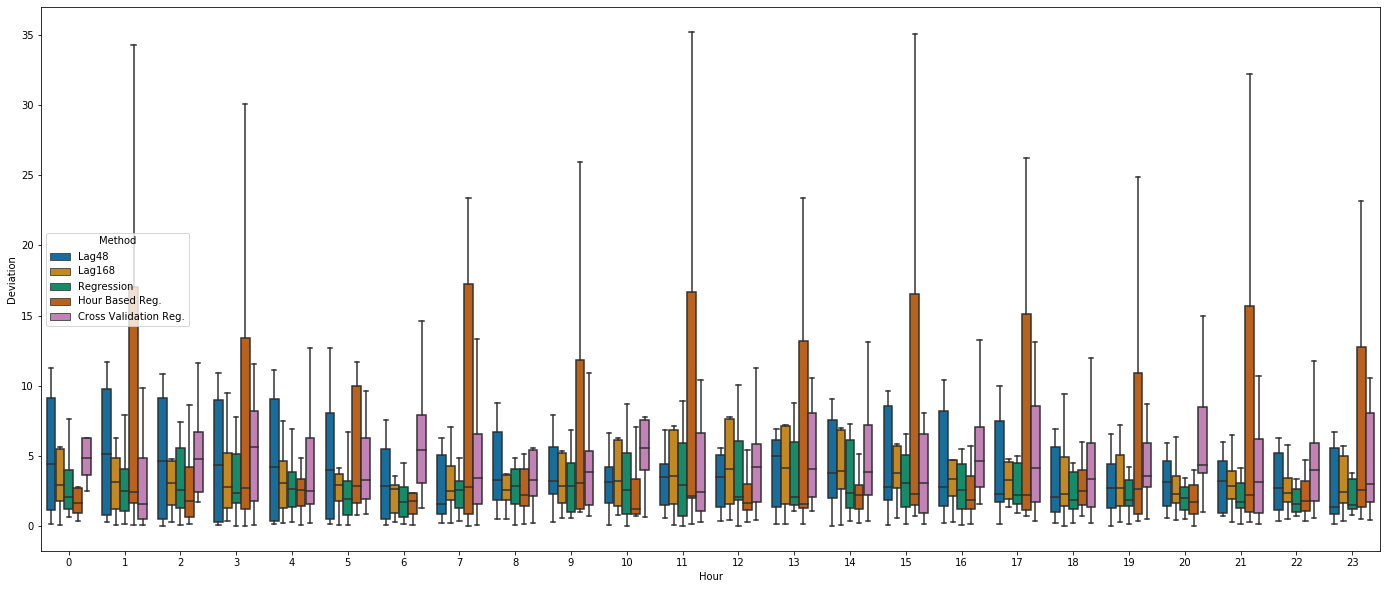

In [10]:
plt.figure(figsize=(24, 10))
sns.boxplot(
    x='Hour',
    y='Deviation',
    data=results, 
    palette='colorblind',
    hue='Method',
    orient='v',
    showfliers=False)
plt.show()

We see that our simple predictors Lag48 and Lag168 have small variance and usually higher bias than other more complicated models. We see that both our regression model and hour-based regression models achieve slightly better accuracy. Hour-based regression models demosntrate high variance due to autocorrelation of the features. This high variance is alleviated significantly when we apply cross-validation and lasso regularization into hourly based models (of course we also use 24 more features). However we see that regressions with lasso does not perform better than our initial regression model built on top of lag predictors.